In [11]:
import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import minmax_scale

import pysal as ps
from pysal.region.maxp import Maxp
from pysal.weights import Queen, Rook, KNN

import matplotlib.pyplot as plt
%matplotlib inline

## Data prep

In [2]:
# dataset can be created with https://github.com/knaaptime/tstracts
store = pd.HDFStore('data/la_msa_data.h5')
attrs = store.study_data
shp = gpd.GeoDataFrame(store.study_tracts) # need to reinitialize as Geodataframe

In [3]:
attrs.head()

,geoid,year,pop,pct_lths,pct_bachelor_or_greater,pct_white,pct_black,pct_hispanic,pct_asian,pct_minority,...,pct_poverty,median_home_value,pct_owner_occupied,median_contract_rent,vacancy_rate,median_household_income,pct_foreign_born,pct_single_mother,housing_units,pct_new_housing_units
3696,06037101110,1980.0,587.090269,61.274509,11.507936,85.296995,0.614955,10.496157,2.040531,14.703005,...,7.239033,227403.569836,75.739403,709.660018,4.975313,59844.338027,8.972746,7.089152,216.045944,0.645651
3697,06037101122,1980.0,6371.203086,61.266336,11.526932,85.299761,0.614342,10.493172,2.042991,14.700239,...,7.234324,227454.095720,75.759869,709.827868,4.969038,59862.053031,8.976141,7.084510,2344.410583,0.645923
3698,06037101210,1980.0,2362.739722,68.875969,9.689922,79.305383,0.184957,16.789971,1.746815,20.694617,...,17.788966,178960.366848,29.279279,630.200006,6.285178,37535.261123,11.652281,19.719473,1035.216064,0.566604
3699,06037101220,1980.0,2503.260114,68.875970,9.689922,79.305386,0.184957,16.789972,1.746815,20.694614,...,17.788966,178960.359979,29.279279,630.200006,6.285178,37535.260904,11.652282,19.719472,1096.783936,0.566604
3700,06037101300,1980.0,3829.761102,57.142858,21.107545,86.795366,0.283140,8.880309,3.371943,13.204634,...,4.736980,251282.671384,86.818846,876.800038,1.451379,69346.659726,10.810811,4.792043,1358.406860,0.798258




`attrs` contains several important tract-level demographic variables from the LTDB database (constructed from https://github.com/knaaptime/tstracts). Currently the data are a timeseries in long-form, so each tract is represented in the dataset 5 times: once each for for 1980, 1990, 2000, 2010, and 2015. Ignoring the temporal dimension for now, we'll use only the 2015 data for a subset of the attributes: race, income, education, and housing price

In [4]:
income = attrs[['geoid','median_household_income', 'year']]
income = income.pivot(index='geoid', columns='year', values='median_household_income')
income = income.dropna()

In [5]:
# subset the data to 2015, keep a handful of variables, and drop missing observations

attrs = attrs[attrs.year == 2015]
attrs = attrs[['geoid', 'year', 'pct_bachelor_or_greater', 'pct_white',
           'pct_black', 'pct_hispanic', 'pct_asian', 'pct_minority',
           'median_household_income', 'median_home_value']]
attrs = attrs.dropna()

In [6]:
# keep the tract FIPS as the identifier, drop the useless 'year' variable, and scale the data w/ min-max

attrs.set_index('geoid', inplace=True)
attrs.drop('year', axis=1, inplace=True)
attrs = attrs.transform(minmax_scale)

In [7]:
# make sure geo and attribute data are in same order to avoide linking weights by ID
attrs.sort_index(inplace=True)
shp.set_index('GEOID', inplace=True)
shp.sort_index(inplace=True)

In [8]:
attrs.head()

,pct_bachelor_or_greater,pct_white,pct_black,pct_hispanic,pct_asian,pct_minority,median_household_income,median_home_value
geoid,,,,,,,,
06037101110,0.219321,0.556799,0.014519,0.337065,0.084603,0.443201,0.161688,0.182312
06037101122,0.307796,0.752355,0.005149,0.123974,0.106005,0.247645,0.400201,0.253920
06037101210,0.187990,0.417035,0.037836,0.487759,0.016538,0.582965,0.114613,0.154875
06037101220,0.224474,0.538939,0.023357,0.259132,0.156818,0.461061,0.121456,0.181005
06037101300,0.351540,0.788662,0.009991,0.103855,0.099898,0.211338,0.288696,0.228493


In [9]:
shp = shp[ shp.index.isin(attrs.index)]
W = Queen.from_dataframe(shp)

/Users/knaaptime/anaconda/lib/python3.6/site-packages/pysal/weights/weights.py:189: UserWarning: There are 3 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/Users/knaaptime/anaconda/lib/python3.6/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 06037620201, 06059062900, 06059063006
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


In [10]:
# these FIPS form two small islands that become disconnected from the rest of the dataset

islands = ['06037620101', '06037620002', '06037620001', '06037620102', '06059062605', '06059062619', '06059062620']

In [12]:
# maybe a way to drop islands in pysal, but manually here
shp = shp[ ~shp.index.isin(['06059063006', '06059062900', '06037620201'])]
shp = shp[ ~shp.index.isin(islands)]
W = Rook.from_dataframe(shp)
K = KNN.from_dataframe(shp, k=5)
W.transform = 'b' # maxp requires binary weights

In [13]:
# drop islands from the attributes too
attrs = attrs.drop(['06059063006', '06059062900', '06037620201'])
attrs = attrs.drop(islands)
income = income.drop(['06059063006', '06059062900', '06037620201'])
income = income.drop(islands)

In [14]:
income.head()
income.sort_index(inplace=True)

In [27]:
attrs.reset_index()

,geoid,pct_bachelor_or_greater,pct_white,pct_black,pct_hispanic,pct_asian,pct_minority,median_household_income,median_home_value
0,06037101110,0.219321,0.556799,0.014519,0.337065,0.084603,0.443201,0.161688,0.182312
1,06037101122,0.307796,0.752355,0.005149,0.123974,0.106005,0.247645,0.400201,0.253920
2,06037101210,0.187990,0.417035,0.037836,0.487759,0.016538,0.582965,0.114613,0.154875
3,06037101220,0.224474,0.538939,0.023357,0.259132,0.156818,0.461061,0.121456,0.181005
4,06037101300,0.351540,0.788662,0.009991,0.103855,0.099898,0.211338,0.288696,0.228493
5,06037101400,0.313626,0.620346,0.009623,0.243125,0.066670,0.379654,0.202450,0.257839
6,06037102103,0.431542,0.748649,0.000000,0.210811,0.038682,0.251351,0.252238,0.236985
7,06037102104,0.497192,0.692904,0.019148,0.139328,0.159965,0.307096,0.263409,0.212664
8,06037102105,0.182290,0.224511,0.030831,0.668383,0.059304,0.775489,0.146020,0.176935
9,06037102107,0.324966,0.550356,0.015802,0.256867,0.184557,0.449644,0.212847,0.264975


In [16]:
# write the attribute data to CSV since Python2 doesn't like HDF5 created w/ py3
attrs.to_csv('data/la_data.csv')
shp.reset_index().to_file('data/la_msa.shp')


In [20]:
w = ps.rook_from_shapefile('data/la_msa.shp')

In [31]:
w.transform = 'b'

## Kmeans and Hierarchical (non-spatial)

In [33]:
# fit non-spatial clusters

kmeans = KMeans(n_clusters=10).fit(attrs)
hierarchical = AgglomerativeClustering(n_clusters=10).fit(attrs)

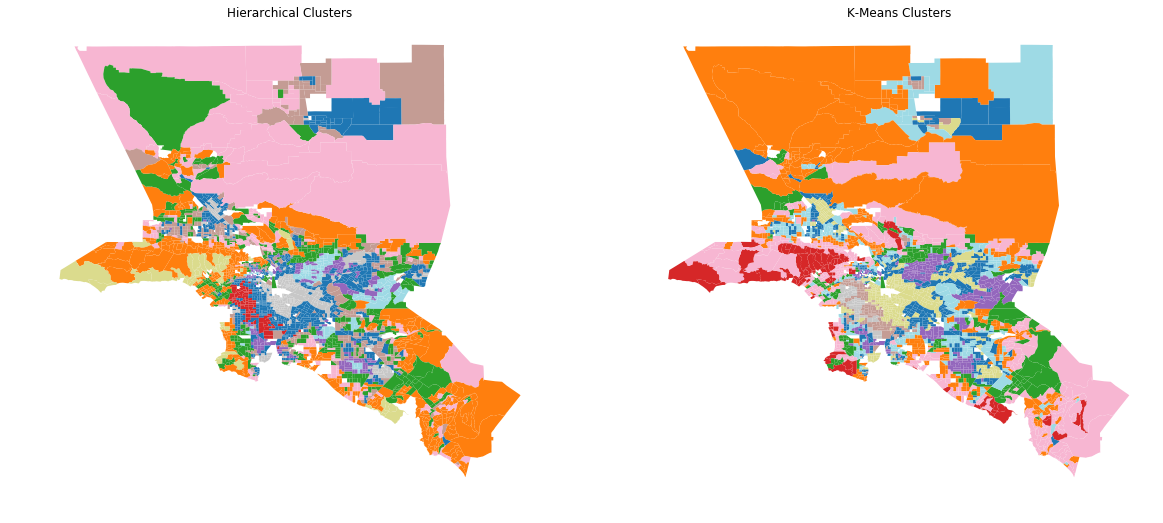

In [34]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,20))

ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_title("Hierarchical Clusters")

ax2.set_aspect('equal')
ax2.axis('off')
ax2.set_title("K-Means Clusters")


shp.merge(attrs.assign(cluster = hierarchical.labels_), left_index=True, right_index=True).plot(column="cluster", cmap="tab20", categorical=True, ax=ax1)
shp.merge(attrs.assign(cluster = kmeans.labels_), left_index=True, right_index=True).plot(column="cluster", cmap='tab20', categorical=True, ax=ax2)

## Max-p

In [88]:
w.

2779

In [37]:
maxp_clusters = Maxp(w, attrs.reset_index().drop('geoid', axis=1).values, floor = 40, floor_variable = np.ones((2779, 1)), initial = 50, verbose=True)

initial solution:  0 434.007838805722 474.671150847885
initial solution:  1 491.6987718055136 434.007838805722
initial solution:  2 442.70217589413704 434.007838805722
initial solution:  3 479.0763785405897 434.007838805722
initial solution:  4 496.9943739407622 434.007838805722
initial solution:  5 469.8960113152127 434.007838805722
initial solution:  6 505.1891393538682 434.007838805722
initial solution:  7 500.92597906803616 434.007838805722
initial solution:  8 439.8743187651556 434.007838805722
initial solution:  9 484.70625260852904 434.007838805722
initial solution:  10 484.0904830500422 434.007838805722
initial solution:  11 480.62171925106156 434.007838805722
initial solution:  12 497.13552596322313 434.007838805722
initial solution:  13 480.61969036206256 434.007838805722
initial solution:  14 472.3432754679421 434.007838805722
initial solution:  15 472.4082576503878 434.007838805722
initial solution:  16 486.68525650039527 434.007838805722
initial solution:  17 470.925055022

internal region:  2 local_attempts:  14
objective function:  423.93033859719594
smallest region size:  40
swap_iteration:  1 moves_made:  49
number of regions:  52
number of changed regions:  13
internal region:  2 local_attempts:  15
objective function:  423.643151700572
smallest region size:  40
swap_iteration:  1 moves_made:  50
number of regions:  52
number of changed regions:  13
internal region:  2 local_attempts:  16
objective function:  423.36064056105954
smallest region size:  40
swap_iteration:  1 moves_made:  51
number of regions:  52
number of changed regions:  13
internal region:  2 local_attempts:  17
objective function:  423.1189070870791
smallest region size:  40
swap_iteration:  1 moves_made:  52
number of regions:  52
number of changed regions:  13
internal region:  2 local_attempts:  18
objective function:  422.88134448948733
smallest region size:  40
swap_iteration:  1 moves_made:  53
number of regions:  52
number of changed regions:  13
internal region:  2 local_at

internal region:  3 local_attempts:  6
objective function:  415.6804270136185
smallest region size:  40
swap_iteration:  1 moves_made:  95
number of regions:  52
number of changed regions:  22
internal region:  3 local_attempts:  7
objective function:  415.43717687982814
smallest region size:  40
swap_iteration:  1 moves_made:  96
number of regions:  52
number of changed regions:  22
internal region:  3 local_attempts:  8
objective function:  415.2159671773714
smallest region size:  40
swap_iteration:  1 moves_made:  97
number of regions:  52
number of changed regions:  22
internal region:  3 local_attempts:  9
objective function:  414.81719502849006
smallest region size:  40
swap_iteration:  1 moves_made:  98
number of regions:  52
number of changed regions:  22
internal region:  3 local_attempts:  10
objective function:  414.34649734129357
smallest region size:  40
swap_iteration:  1 moves_made:  99
number of regions:  52
number of changed regions:  22
internal region:  3 local_attem

swap_iteration:  1 moves_made:  161
number of regions:  52
number of changed regions:  31
internal region:  6 local_attempts:  18
objective function:  404.5795992058396
smallest region size:  40
swap_iteration:  1 moves_made:  162
number of regions:  52
number of changed regions:  31
internal region:  6 local_attempts:  19
objective function:  404.45124035750626
smallest region size:  40
swap_iteration:  1 moves_made:  163
number of regions:  52
number of changed regions:  31
internal region:  6 local_attempts:  20
objective function:  404.38950291578084
smallest region size:  40
swap_iteration:  1 moves_made:  164
number of regions:  52
number of changed regions:  31
internal region:  6 local_attempts:  21
objective function:  404.3261829714262
smallest region size:  40
swap_iteration:  1 moves_made:  165
number of regions:  52
number of changed regions:  31
internal region:  6 local_attempts:  22
objective function:  404.2900301655338
smallest region size:  40
swap_iteration:  1 move

swap_iteration:  1 moves_made:  242
number of regions:  52
number of changed regions:  41
internal region:  11 local_attempts:  8
objective function:  384.37290411169613
smallest region size:  40
swap_iteration:  1 moves_made:  243
number of regions:  52
number of changed regions:  41
internal region:  11 local_attempts:  9
objective function:  384.211002183223
smallest region size:  40
swap_iteration:  1 moves_made:  244
number of regions:  52
number of changed regions:  42
internal region:  11 local_attempts:  10
objective function:  384.0620071592465
smallest region size:  40
swap_iteration:  1 moves_made:  245
number of regions:  52
number of changed regions:  42
internal region:  11 local_attempts:  11
objective function:  383.8885285572563
smallest region size:  40
swap_iteration:  1 moves_made:  246
number of regions:  52
number of changed regions:  42
internal region:  11 local_attempts:  12
objective function:  383.7567079695616
smallest region size:  40
swap_iteration:  1 mov

smallest region size:  40
swap_iteration:  1 moves_made:  303
number of regions:  52
number of changed regions:  45
internal region:  13 local_attempts:  18
objective function:  370.1350783219155
smallest region size:  40
swap_iteration:  1 moves_made:  304
number of regions:  52
number of changed regions:  45
internal region:  13 local_attempts:  19
objective function:  370.0621094099267
smallest region size:  40
swap_iteration:  1 moves_made:  305
number of regions:  52
number of changed regions:  45
internal region:  13 local_attempts:  20
objective function:  369.97527723495796
smallest region size:  40
swap_iteration:  1 moves_made:  306
number of regions:  52
number of changed regions:  45
internal region:  13 local_attempts:  21
objective function:  369.8764656785134
smallest region size:  40
swap_iteration:  1 moves_made:  307
number of regions:  52
number of changed regions:  45
internal region:  13 local_attempts:  22
objective function:  369.8078780286192
smallest region siz

internal region:  17 local_attempts:  9
objective function:  358.3671779070722
smallest region size:  40
swap_iteration:  1 moves_made:  366
number of regions:  52
number of changed regions:  47
internal region:  17 local_attempts:  10
objective function:  358.1654390937714
smallest region size:  40
swap_iteration:  1 moves_made:  367
number of regions:  52
number of changed regions:  47
internal region:  17 local_attempts:  11
objective function:  357.98491864433737
smallest region size:  40
swap_iteration:  1 moves_made:  368
number of regions:  52
number of changed regions:  47
internal region:  17 local_attempts:  12
objective function:  357.8315238502263
smallest region size:  40
swap_iteration:  1 moves_made:  369
number of regions:  52
number of changed regions:  47
internal region:  17 local_attempts:  13
objective function:  357.6945775612395
smallest region size:  40
swap_iteration:  1 moves_made:  370
number of regions:  52
number of changed regions:  47
internal region:  17

smallest region size:  40
swap_iteration:  1 moves_made:  451
number of regions:  52
number of changed regions:  47
internal region:  21 local_attempts:  14
objective function:  342.11572501100153
smallest region size:  40
swap_iteration:  1 moves_made:  452
number of regions:  52
number of changed regions:  47
internal region:  21 local_attempts:  15
objective function:  341.8079476488364
smallest region size:  40
swap_iteration:  1 moves_made:  453
number of regions:  52
number of changed regions:  47
internal region:  21 local_attempts:  16
objective function:  341.61546517200287
smallest region size:  40
swap_iteration:  1 moves_made:  454
number of regions:  52
number of changed regions:  47
internal region:  21 local_attempts:  17
objective function:  341.4595001853988
smallest region size:  40
swap_iteration:  1 moves_made:  455
number of regions:  52
number of changed regions:  47
internal region:  21 local_attempts:  18
objective function:  341.29675900045777
smallest region s

number of regions:  52
number of changed regions:  50
internal region:  27 local_attempts:  17
objective function:  325.256151097932
smallest region size:  40
swap_iteration:  1 moves_made:  513
number of regions:  52
number of changed regions:  50
internal region:  27 local_attempts:  18
objective function:  325.10478229614307
smallest region size:  40
swap_iteration:  1 moves_made:  514
number of regions:  52
number of changed regions:  50
internal region:  27 local_attempts:  19
objective function:  324.96863558410746
smallest region size:  40
swap_iteration:  1 moves_made:  515
number of regions:  52
number of changed regions:  50
internal region:  27 local_attempts:  20
objective function:  324.874360686587
smallest region size:  40
swap_iteration:  1 moves_made:  516
number of regions:  52
number of changed regions:  50
internal region:  27 local_attempts:  21
objective function:  324.78163546584744
smallest region size:  40
swap_iteration:  1 moves_made:  517
number of regions: 

objective function:  315.6343404277313
smallest region size:  40
swap_iteration:  1 moves_made:  566
number of regions:  52
number of changed regions:  51
internal region:  31 local_attempts:  4
objective function:  315.36490767918406
smallest region size:  40
swap_iteration:  1 moves_made:  567
number of regions:  52
number of changed regions:  51
internal region:  31 local_attempts:  5
objective function:  315.19943494115796
smallest region size:  40
swap_iteration:  1 moves_made:  568
number of regions:  52
number of changed regions:  51
internal region:  31 local_attempts:  6
objective function:  315.074305366106
smallest region size:  40
swap_iteration:  1 moves_made:  569
number of regions:  52
number of changed regions:  51
internal region:  31 local_attempts:  7
objective function:  314.9437295355149
smallest region size:  40
swap_iteration:  1 moves_made:  570
number of regions:  52
number of changed regions:  51
internal region:  31 local_attempts:  8
objective function:  314

number of changed regions:  52
internal region:  34 local_attempts:  25
objective function:  306.8808162696645
smallest region size:  40
swap_iteration:  1 moves_made:  627
number of regions:  52
number of changed regions:  52
internal region:  34 local_attempts:  26
objective function:  306.8808162696645
smallest region size:  40
swap_iteration:  1 moves_made:  628
number of regions:  52
number of changed regions:  52
internal region:  35 local_attempts:  1
objective function:  306.750995403017
smallest region size:  40
swap_iteration:  1 moves_made:  629
number of regions:  52
number of changed regions:  52
internal region:  35 local_attempts:  2
objective function:  306.6877519086027
smallest region size:  40
swap_iteration:  1 moves_made:  630
number of regions:  52
number of changed regions:  52
internal region:  35 local_attempts:  3
objective function:  306.58170957657603
smallest region size:  40
swap_iteration:  1 moves_made:  631
number of regions:  52
number of changed regio

smallest region size:  40
swap_iteration:  1 moves_made:  686
number of regions:  52
number of changed regions:  52
internal region:  36 local_attempts:  12
objective function:  304.90125569564464
smallest region size:  40
swap_iteration:  1 moves_made:  687
number of regions:  52
number of changed regions:  52
internal region:  36 local_attempts:  13
objective function:  304.8122062342447
smallest region size:  40
swap_iteration:  1 moves_made:  687
number of regions:  52
number of changed regions:  52
internal region:  36 local_attempts:  14
objective function:  304.8122062342447
smallest region size:  40
swap_iteration:  1 moves_made:  688
number of regions:  52
number of changed regions:  52
internal region:  37 local_attempts:  1
objective function:  304.5656524726822
smallest region size:  40
swap_iteration:  1 moves_made:  689
number of regions:  52
number of changed regions:  52
internal region:  37 local_attempts:  2
objective function:  304.4630932606245
smallest region size:

swap_iteration:  1 moves_made:  747
number of regions:  52
number of changed regions:  52
internal region:  41 local_attempts:  21
objective function:  295.334248207539
smallest region size:  40
swap_iteration:  1 moves_made:  748
number of regions:  52
number of changed regions:  52
internal region:  41 local_attempts:  22
objective function:  295.22750798982406
smallest region size:  40
swap_iteration:  1 moves_made:  749
number of regions:  52
number of changed regions:  52
internal region:  41 local_attempts:  23
objective function:  295.1697650848754
smallest region size:  40
swap_iteration:  1 moves_made:  750
number of regions:  52
number of changed regions:  52
internal region:  41 local_attempts:  24
objective function:  295.1217415784084
smallest region size:  40
swap_iteration:  1 moves_made:  751
number of regions:  52
number of changed regions:  52
internal region:  41 local_attempts:  25
objective function:  295.0208644372457
smallest region size:  40
swap_iteration:  1 m

number of changed regions:  52
internal region:  47 local_attempts:  5
objective function:  285.47929440463116
smallest region size:  40
swap_iteration:  1 moves_made:  800
number of regions:  52
number of changed regions:  52
internal region:  47 local_attempts:  6
objective function:  285.3857905459213
smallest region size:  40
swap_iteration:  1 moves_made:  801
number of regions:  52
number of changed regions:  52
internal region:  47 local_attempts:  7
objective function:  285.2928189344044
smallest region size:  40
swap_iteration:  1 moves_made:  802
number of regions:  52
number of changed regions:  52
internal region:  47 local_attempts:  8
objective function:  285.22517757634023
smallest region size:  40
swap_iteration:  1 moves_made:  803
number of regions:  52
number of changed regions:  52
internal region:  47 local_attempts:  9
objective function:  285.13473811006804
smallest region size:  40
swap_iteration:  1 moves_made:  804
number of regions:  52
number of changed regi

smallest region size:  40
swap_iteration:  1 moves_made:  864
number of regions:  52
number of changed regions:  52
internal region:  49 local_attempts:  10
objective function:  279.7389127121828
smallest region size:  40
swap_iteration:  1 moves_made:  864
number of regions:  52
number of changed regions:  52
internal region:  49 local_attempts:  11
objective function:  279.7389127121828
smallest region size:  40
swap_iteration:  1 moves_made:  865
number of regions:  52
number of changed regions:  52
internal region:  50 local_attempts:  1
objective function:  279.6249126523872
smallest region size:  40
swap_iteration:  1 moves_made:  866
number of regions:  52
number of changed regions:  52
internal region:  50 local_attempts:  2
objective function:  279.6097049710454
smallest region size:  40
swap_iteration:  1 moves_made:  867
number of regions:  52
number of changed regions:  52
internal region:  50 local_attempts:  3
objective function:  279.59366617860223
smallest region size: 

number of regions:  52
number of changed regions:  26
internal region:  12 local_attempts:  7
objective function:  274.0650286925123
smallest region size:  40
swap_iteration:  2 moves_made:  56
number of regions:  52
number of changed regions:  26
internal region:  12 local_attempts:  8
objective function:  274.0578646342893
smallest region size:  40
swap_iteration:  2 moves_made:  57
number of regions:  52
number of changed regions:  26
internal region:  12 local_attempts:  9
objective function:  274.04131311104743
smallest region size:  40
swap_iteration:  2 moves_made:  58
number of regions:  52
number of changed regions:  26
internal region:  12 local_attempts:  10
objective function:  274.0031493882713
smallest region size:  40
swap_iteration:  2 moves_made:  59
number of regions:  52
number of changed regions:  26
internal region:  12 local_attempts:  11
objective function:  273.97932117869357
smallest region size:  40
swap_iteration:  2 moves_made:  60
number of regions:  52
num

internal region:  21 local_attempts:  11
objective function:  268.92380084963236
smallest region size:  40
swap_iteration:  2 moves_made:  114
number of regions:  52
number of changed regions:  32
internal region:  21 local_attempts:  12
objective function:  268.90117802574736
smallest region size:  40
swap_iteration:  2 moves_made:  115
number of regions:  52
number of changed regions:  32
internal region:  21 local_attempts:  13
objective function:  268.8815695095626
smallest region size:  40
swap_iteration:  2 moves_made:  115
number of regions:  52
number of changed regions:  32
internal region:  21 local_attempts:  14
objective function:  268.8815695095626
smallest region size:  40
swap_iteration:  2 moves_made:  116
number of regions:  52
number of changed regions:  34
internal region:  22 local_attempts:  1
objective function:  268.5470647553026
smallest region size:  40
swap_iteration:  2 moves_made:  117
number of regions:  52
number of changed regions:  34
internal region:  2

number of changed regions:  42
internal region:  30 local_attempts:  6
objective function:  260.7705526167984
smallest region size:  40
swap_iteration:  2 moves_made:  163
number of regions:  52
number of changed regions:  42
internal region:  30 local_attempts:  7
objective function:  260.7661364027968
smallest region size:  40
swap_iteration:  2 moves_made:  164
number of regions:  52
number of changed regions:  42
internal region:  30 local_attempts:  8
objective function:  260.7614451504222
smallest region size:  40
swap_iteration:  2 moves_made:  165
number of regions:  52
number of changed regions:  42
internal region:  30 local_attempts:  9
objective function:  260.75565514502256
smallest region size:  40
swap_iteration:  2 moves_made:  166
number of regions:  52
number of changed regions:  42
internal region:  30 local_attempts:  10
objective function:  260.7549735749243
smallest region size:  40
swap_iteration:  2 moves_made:  166
number of regions:  52
number of changed regio

number of changed regions:  46
internal region:  38 local_attempts:  11
objective function:  257.13126908170557
smallest region size:  40
swap_iteration:  2 moves_made:  220
number of regions:  52
number of changed regions:  46
internal region:  38 local_attempts:  12
objective function:  256.9959334951101
smallest region size:  40
swap_iteration:  2 moves_made:  221
number of regions:  52
number of changed regions:  46
internal region:  38 local_attempts:  13
objective function:  256.8949632170374
smallest region size:  40
swap_iteration:  2 moves_made:  222
number of regions:  52
number of changed regions:  46
internal region:  38 local_attempts:  14
objective function:  256.7552836548754
smallest region size:  40
swap_iteration:  2 moves_made:  222
number of regions:  52
number of changed regions:  46
internal region:  38 local_attempts:  15
objective function:  256.7552836548754
smallest region size:  40
swap_iteration:  2 moves_made:  222
number of regions:  52
number of changed r

internal region:  6 local_attempts:  6
objective function:  248.20997778754074
smallest region size:  40
swap_iteration:  3 moves_made:  11
number of regions:  52
number of changed regions:  5
internal region:  6 local_attempts:  7
objective function:  248.20997778754074
smallest region size:  40
swap_iteration:  3 moves_made:  12
number of regions:  52
number of changed regions:  7
internal region:  8 local_attempts:  1
objective function:  248.09324819891904
smallest region size:  40
swap_iteration:  3 moves_made:  13
number of regions:  52
number of changed regions:  7
internal region:  8 local_attempts:  2
objective function:  248.01106127925888
smallest region size:  40
swap_iteration:  3 moves_made:  14
number of regions:  52
number of changed regions:  7
internal region:  8 local_attempts:  3
objective function:  247.72622649173994
smallest region size:  40
swap_iteration:  3 moves_made:  15
number of regions:  52
number of changed regions:  7
internal region:  8 local_attempts:

swap_iteration:  3 moves_made:  59
number of regions:  52
number of changed regions:  27
internal region:  29 local_attempts:  3
objective function:  244.4803181141138
smallest region size:  40
swap_iteration:  3 moves_made:  59
number of regions:  52
number of changed regions:  27
internal region:  29 local_attempts:  4
objective function:  244.4803181141138
smallest region size:  40
swap_iteration:  3 moves_made:  60
number of regions:  52
number of changed regions:  27
internal region:  30 local_attempts:  1
objective function:  244.4434903993132
smallest region size:  40
swap_iteration:  3 moves_made:  60
number of regions:  52
number of changed regions:  27
internal region:  30 local_attempts:  2
objective function:  244.4434903993132
smallest region size:  40
swap_iteration:  3 moves_made:  60
number of regions:  52
number of changed regions:  27
internal region:  31 local_attempts:  1
objective function:  244.4434903993132
smallest region size:  40
swap_iteration:  3 moves_made:

objective function:  242.9028379878184
smallest region size:  40
swap_iteration:  4 moves_made:  3
number of regions:  52
number of changed regions:  5
internal region:  9 local_attempts:  1
objective function:  242.90128113092743
smallest region size:  40
swap_iteration:  4 moves_made:  3
number of regions:  52
number of changed regions:  5
internal region:  9 local_attempts:  2
objective function:  242.90128113092743
smallest region size:  40
swap_iteration:  4 moves_made:  3
number of regions:  52
number of changed regions:  5
internal region:  10 local_attempts:  1
objective function:  242.90128113092743
smallest region size:  40
swap_iteration:  4 moves_made:  4
number of regions:  52
number of changed regions:  7
internal region:  11 local_attempts:  1
objective function:  242.69991468853635
smallest region size:  40
swap_iteration:  4 moves_made:  4
number of regions:  52
number of changed regions:  7
internal region:  11 local_attempts:  2
objective function:  242.6999146885363

## Hierarchical w/ Spatial Constraints

In [67]:
ward = AgglomerativeClustering(n_clusters=15, linkage='ward',
                               connectivity=W.full()[0]).fit(attrs)

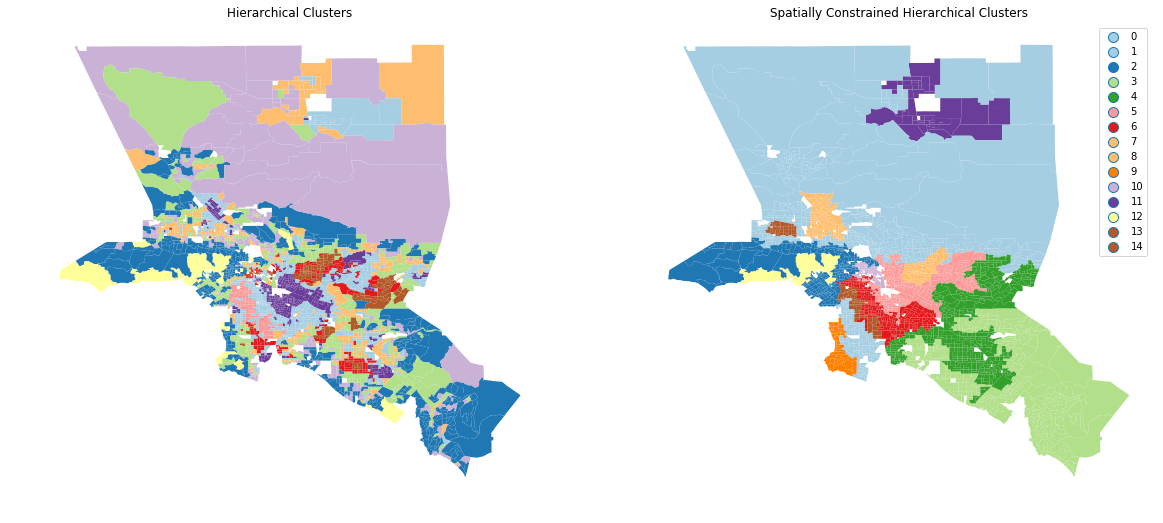

In [68]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,20))

ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_title("Hierarchical Clusters")

ax2.set_aspect('equal')
ax2.axis('off')
ax2.set_title("Spatially Constrained Hierarchical Clusters")


shp.merge(attrs.assign(cluster = hierarchical.labels_), left_index=True, right_index=True).plot(column="cluster", categorical=True, ax=ax1, cmap='Paired')
shp.merge(attrs.assign(cluster = ward.labels_), left_index=True, right_index=True).plot(column="cluster", categorical=True, legend=True, cmap='Paired', linewidth=0, ax=ax2)

Two issues here:

- Maxp gives no result; tried with queen and rook, maybe try distance-based?
    - ** Update** - it appears the lack of results here was also due to misalignment with the weights matrix. I can get results when using sorted weights matrix and cranking the `floor` down to 3, but the result is incomprehensible with the huge number of clusters. Need to keep experimenting  


- Results from spatially constrained agglomerative clustering are a little weird. Tried varying K, contiguity, and W-transforms, no change in results. Maybe adding connectivity matrix imposes some kind of soft constraint? (like [here](https://arxiv.org/abs/1707.03897) but with no control over $\alpha$?)
    - **Update** - it looks like the weirdness was induced by the weights matrix... apparently using the `idVariable` argument when constructing the weights matrix doesn't hold up when running the clustering algorithm (i.e. the neighbors are assigned incorrectly). Instead, we should omit the idVariable and sort the shapefile and the attributes by their indexes, which gives proper alignment

In [66]:
mp = pd.DataFrame().from_dict(maxp_clusters.area2region, orient='index').sort_index()
mp.columns = ['cluster']


#pd.DataFrame(maxp_clusters.area2region, index=[0]).T.groupby(0).sum()

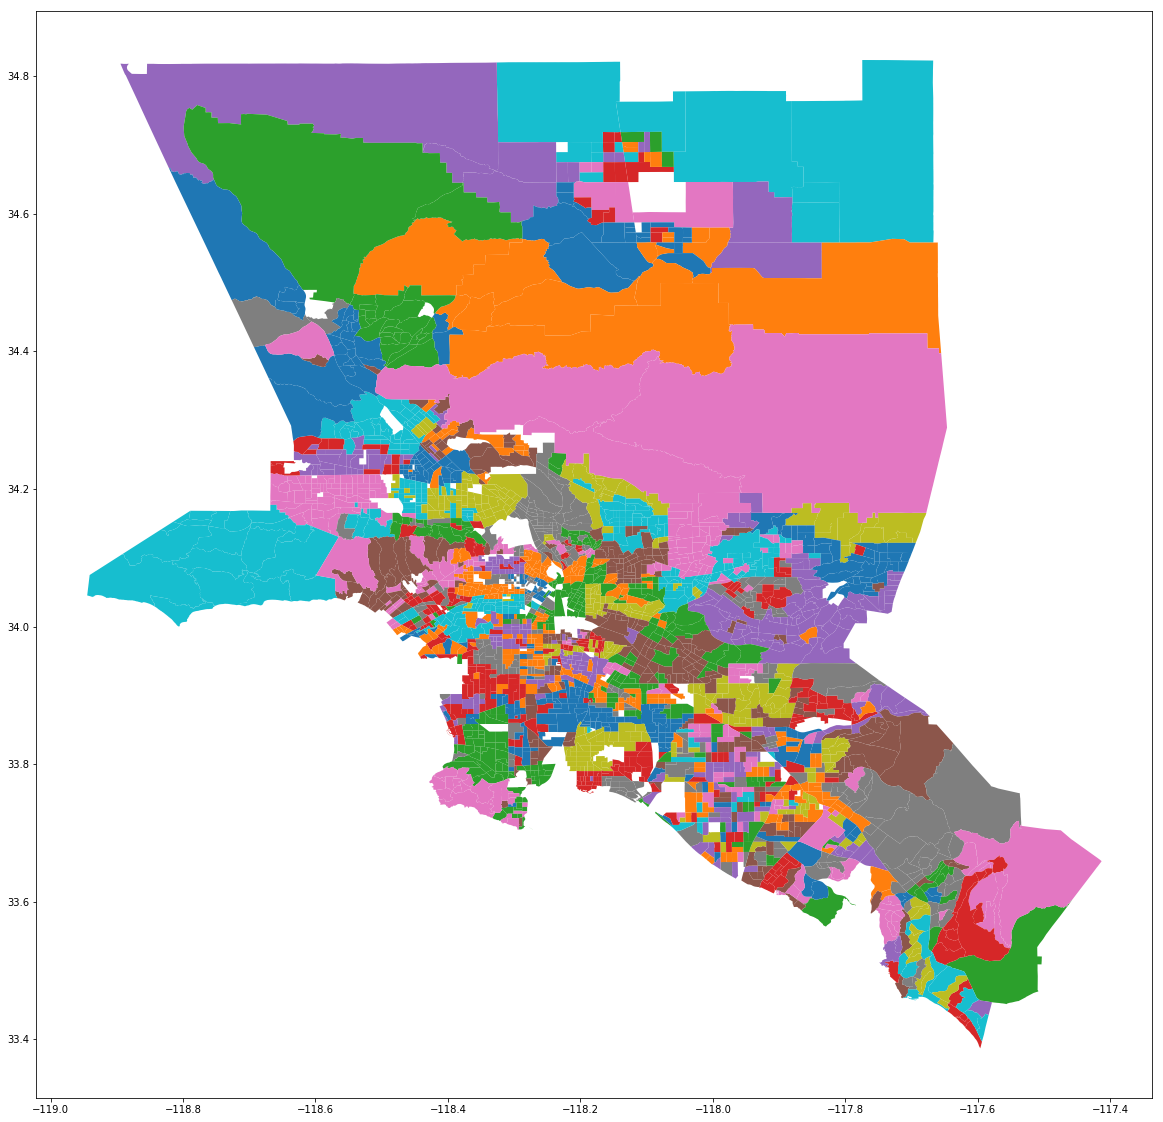

In [81]:
fig, ax = plt.subplots(figsize=(20,20))

shp.merge(attrs.assign(maxp_cluster = maxp_clusters.area2region), left_index=True, right_index=True).plot(column="maxp_cluster",  categorical=True, ax=ax)


In [54]:
%load_ext watermark


In [59]:
%watermark

2018-02-02T09:51:18-08:00

CPython 3.6.3
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)
system     : Darwin
release    : 17.4.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [37]:
maxp_clusters.area2region

{'06059089105': 100,
 '06059089104': 100,
 '06059075201': 125,
 '06059099248': 100,
 '06059099249': 0,
 '06059074801': 125,
 '06059074803': 100,
 '06059075302': 0,
 '06059089004': 0,
 '06059089102': 0,
 '06037501900': 1,
 '06037502005': 1,
 '06037502902': 18,
 '06037503103': 18,
 '06037503202': 1,
 '06037503201': 1,
 '06037502901': 1,
 '06037501802': 1,
 '06037502700': 18,
 '06037500202': 137,
 '06037197420': 12,
 '06037195600': 12,
 '06037197300': 2,
 '06037197600': 2,
 '06037197410': 2,
 '06037195804': 12,
 '06037187300': 2,
 '06037197500': 2,
 '06037208000': 2,
 '06037195100': 133,
 '06037143800': 48,
 '06037194102': 4,
 '06037194200': 3,
 '06037700502': 3,
 '06037700501': 3,
 '06037143700': 48,
 '06037189702': 3,
 '06037700400': 3,
 '06037700300': 3,
 '06037189800': 3,
 '06037262100': 4,
 '06037141600': 4,
 '06037141700': 4,
 '06037143902': 48,
 '06037141400': 48,
 '06037141202': 48,
 '06037141102': 48,
 '06037700700': 4,
 '06037141101': 48,
 '06037700801': 3,
 '06037141303': 48,
 

In [62]:
attrs.assign(maxp_cluster = maxp_clusters.area2region).head()

,pct_bachelor_or_greater,pct_white,pct_black,pct_hispanic,pct_asian,pct_minority,median_household_income,median_home_value,maxp_cluster
geoid,,,,,,,,,
06037101110,0.219321,0.556799,0.014519,0.337065,0.084603,0.443201,0.161688,0.182312,2654
06037101122,0.307796,0.752355,0.005149,0.123974,0.106005,0.247645,0.400201,0.253920,2693
06037101210,0.187990,0.417035,0.037836,0.487759,0.016538,0.582965,0.114613,0.154875,2656
06037101220,0.224474,0.538939,0.023357,0.259132,0.156818,0.461061,0.121456,0.181005,2692
06037101300,0.351540,0.788662,0.009991,0.103855,0.099898,0.211338,0.288696,0.228493,2691


In [32]:
attrs

,pct_bachelor_or_greater,pct_white,pct_black,pct_hispanic,pct_asian,pct_minority,median_household_income,median_home_value
geoid,,,,,,,,
06037101110,0.219321,0.556799,0.014519,0.337065,0.084603,0.443201,0.161688,0.182312
06037101122,0.307796,0.752355,0.005149,0.123974,0.106005,0.247645,0.400201,0.253920
06037101210,0.187990,0.417035,0.037836,0.487759,0.016538,0.582965,0.114613,0.154875
06037101220,0.224474,0.538939,0.023357,0.259132,0.156818,0.461061,0.121456,0.181005
06037101300,0.351540,0.788662,0.009991,0.103855,0.099898,0.211338,0.288696,0.228493
06037101400,0.313626,0.620346,0.009623,0.243125,0.066670,0.379654,0.202450,0.257839
06037102103,0.431542,0.748649,0.000000,0.210811,0.038682,0.251351,0.252238,0.236985
06037102104,0.497192,0.692904,0.019148,0.139328,0.159965,0.307096,0.263409,0.212664
06037102105,0.182290,0.224511,0.030831,0.668383,0.059304,0.775489,0.146020,0.176935


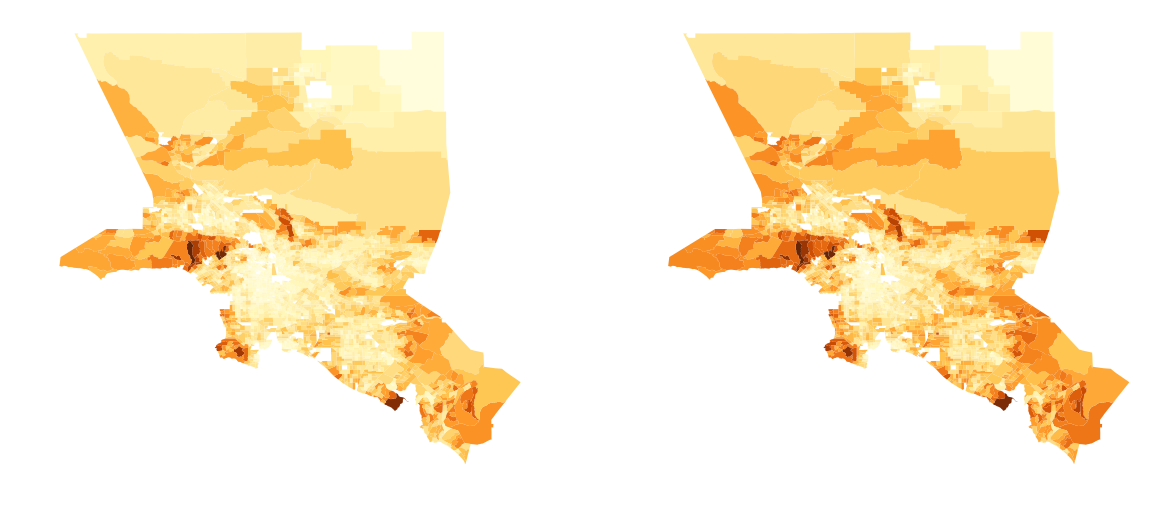

In [104]:
fig, (ax, ax2) = plt.subplots(1,2, figsize=(20,20))
ax.set_aspect('equal')
ax.axis('off')

ax2.set_aspect('equal')
ax2.axis('off')




shp.merge(attrs, left_index=True, right_index=True).plot(column="median_household_income", cmap='YlOrBr', ax=ax)
shp.merge(attrs.apply(np.log1p), left_index=True, right_index=True).plot(column="median_household_income", cmap='YlOrBr', ax=ax2)


In [73]:
mp.describe()

,cluster
count,2779
unique,52
top,35
freq,104


In [72]:
mp.cluster = mp.cluster.astype(str)

In [78]:
mp['cols'] = 1

In [80]:
mp.groupby('cluster').count()

,cols
cluster,
0,54
1,52
10,75
11,90
12,49
13,74
14,47
15,40
16,45
